**CREDIT SCORE MODELLING**
This model uses a [ Kaggle Dataset](https://www.kaggle.com/c/GiveMeSomeCredit) about credit repayment difficulty rates among customers. 

Tha aim is to improve on the state of the art in credit scoring by predicting the probability that somebody will experience financial distress in the next two years.

**DATASET VARIABLES:** 

**SeriousDlqin2yrs (Target variable)** : Person experienced 90 days past due delinquency or worse.

It is the target variable (label)

**RevolvingUtilizationOfUnsecuredLines** : Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits

**age** : Age of borrower in years

**NumberOfTime30-59DaysPastDueNotWorse** : Number of times borrower has been 30-59 days past due but no worse in the last 2 years

**DebtRatio** : Monthly debt payments, alimony,living costs divided by monthy gross income

**MonthlyIncome** : Monthly income

**NumberOfOpenCreditLinesAndLoans** : Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards)

**NumberOfTimes90DaysLate** : Number of times borrower has been 90 days or more past due

**NumberRealEstateLoansOrLines** : Number of mortgage and real estate loans including home equity lines of credit

**NumberOfTime60-89DaysPastDueNotWorse** : Number of times borrower has been 60-89 days past due but no worse in the last 2 years

**NumberOfDependents** : Number of dependents in family excluding themselves (spouse, children etc.)



In [925]:
#Importing libraries
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=Warning)

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='white', context='notebook', palette='deep')
from collections import Counter
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier


In [926]:
#Training dataset
train_df = pd.read_csv('cs-training.csv')
train_df.shape

(150000, 12)

In [927]:
train_df.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [928]:
#Test dataset
test_df = pd.read_csv('cs-test.csv')
test_df.shape

(101503, 12)

**Understanding Data**


In [929]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            150000 non-null  int64  
 1   SeriousDlqin2yrs                      150000 non-null  int64  
 2   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 3   age                                   150000 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 5   DebtRatio                             150000 non-null  float64
 6   MonthlyIncome                         120269 non-null  float64
 7   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 8   NumberOfTimes90DaysLate               150000 non-null  int64  
 9   NumberRealEstateLoansOrLines          150000 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 11  

In [930]:
train_df.isnull().sum()

Unnamed: 0                                  0
SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

In [931]:
test_df.isnull().sum()

Unnamed: 0                                   0
SeriousDlqin2yrs                        101503
RevolvingUtilizationOfUnsecuredLines         0
age                                          0
NumberOfTime30-59DaysPastDueNotWorse         0
DebtRatio                                    0
MonthlyIncome                            20103
NumberOfOpenCreditLinesAndLoans              0
NumberOfTimes90DaysLate                      0
NumberRealEstateLoansOrLines                 0
NumberOfTime60-89DaysPastDueNotWorse         0
NumberOfDependents                        2626
dtype: int64

Both training and test datasets contains missing values in two columns. First we have to either fill these missing values or remove the missing values data. Here we are replacing the missing values with the median in 'MonthlyIncome' column after removing the outliers in training dataset if any, and with 0 in 'NumberOfdependents' column.

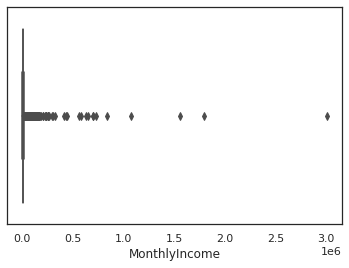

In [932]:
# Boxplot to check for the outliers
sns.boxplot(train_df['MonthlyIncome'])

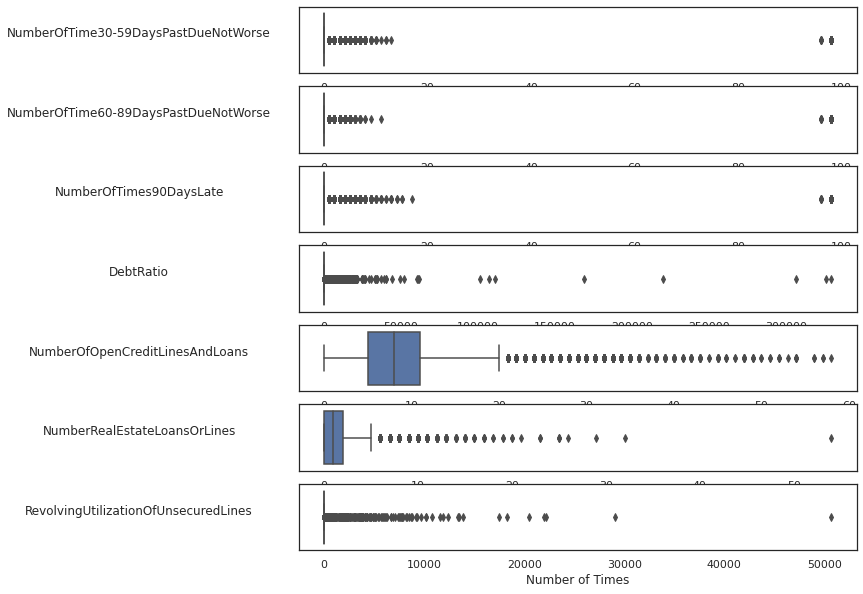

In [933]:
#Boxplot for the training datset

cols = ["NumberOfTime30-59DaysPastDueNotWorse","NumberOfTime60-89DaysPastDueNotWorse","NumberOfTimes90DaysLate", "DebtRatio","NumberOfOpenCreditLinesAndLoans","NumberRealEstateLoansOrLines", "RevolvingUtilizationOfUnsecuredLines"]
fig, axes = plt.subplots(len(cols),1, figsize=(10,10))
i = 0
for c in cols:
    ax = sns.boxplot(train_df[c], ax = axes[i])
    ax.set_ylabel(c, rotation=0, labelpad=150)
    ax.set_xlabel("Number of Times")
    i +=1
plt.show()

We can clearly see the presence of outliers in the dataset.
Let's write code to remove the outliers from all the columns present in the dataset using Interquartile range (IQR).

In [934]:
#IQR function

def detect_outliers(df,n,features):
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers

In [935]:
#Training dataset outliers

detected_outliers = detect_outliers(train_df,2,["RevolvingUtilizationOfUnsecuredLines",
                                            "age",
                                            "NumberOfTime30-59DaysPastDueNotWorse",
                                            "DebtRatio",
                                            "MonthlyIncome",
                                            "NumberOfOpenCreditLinesAndLoans",
                                            "NumberOfTimes90DaysLate",
                                            "NumberRealEstateLoansOrLines",
                                            "NumberOfTime60-89DaysPastDueNotWorse",
                                            "Unnamed: 0",
                                            "NumberOfDependents"])

In [936]:
train_df.loc[detected_outliers]

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
900,901,0,2.258964,33,2,0.032484,2000.0,1,1,0,0,2.0
919,920,1,1.362142,73,1,274.000000,NaN,2,3,0,1,NaN
1958,1959,0,1.634551,28,0,151.000000,NaN,1,3,0,2,0.0
4852,4853,0,1.566866,46,2,0.104983,6000.0,3,2,0,0,0.0
5956,5957,0,2.237856,60,6,2597.000000,1.0,16,1,2,1,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
117338,117339,1,0.960692,42,0,1.241580,3770.0,29,1,2,1,3.0
126682,126683,1,0.344297,38,0,1.789158,4500.0,23,14,11,1,0.0
129570,129571,0,0.075067,58,0,0.298925,17388.0,24,0,6,1,0.0
5833,5834,1,0.917527,44,0,1.852144,3800.0,13,1,7,1,1.0


In [937]:
train_df = train_df.drop(detected_outliers, axis = 0).reset_index(drop=True)

In [938]:
train_df.MonthlyIncome.median()

5416.0

In [939]:
test_df.MonthlyIncome.median()

5400.0

In [940]:
train_df.MonthlyIncome = train_df.MonthlyIncome.fillna(train_df.MonthlyIncome.median())
test_df.MonthlyIncome = test_df.MonthlyIncome.fillna(test_df.MonthlyIncome.median())

In [941]:
train_df.NumberOfDependents = train_df.NumberOfDependents.fillna(0)
test_df.NumberOfDependents = test_df.NumberOfDependents.fillna(0)

In [942]:
train_df.shape

(146473, 12)

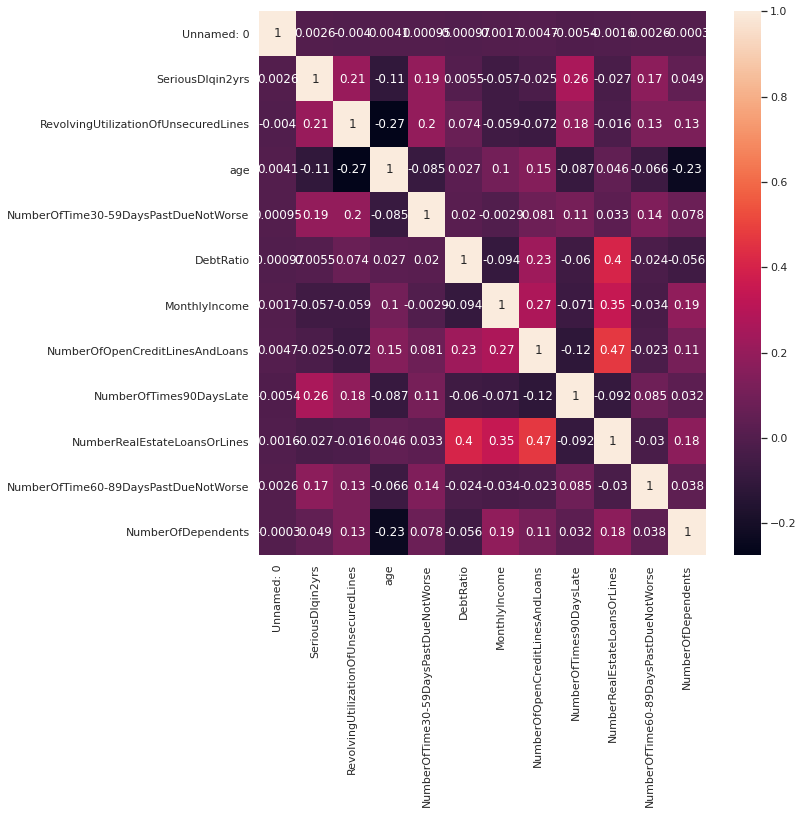

In [943]:
# Correlation matrix
corr_mtx = train_df.corr(method='spearman')
        
plt.figure(figsize = (10,10))

sns.heatmap(corr_mtx, xticklabels=corr_mtx.columns, yticklabels=corr_mtx.columns, annot=True)
plt.show()

We can see that the Target variable has the highest correlation with 'NumberOfTimes90DaysLate', 'NumberOfTime60-89DaysPastDueNotWorse', and 'RevolvingUtilizationOfUnsecuredLines'. So we will first investigate 'RevolvingUtilizationOfUnsecuredLines' more.



In [944]:
train_df.RevolvingUtilizationOfUnsecuredLines.describe()

count    146473.000000
mean          5.933029
std         249.407744
min           0.000000
25%           0.028876
50%           0.146277
75%           0.530833
max       50708.000000
Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64

In [945]:
train_df = train_df.rename(columns={'Unnamed: 0': 'Unknown',
                                  'SeriousDlqin2yrs': 'Target',
                                  'RevolvingUtilizationOfUnsecuredLines': 'UnsecLines',
                                  'NumberOfTime30-59DaysPastDueNotWorse': 'Late3059',
                                  'DebtRatio': 'DebtRatio',
                                  'MonthlyIncome': 'MonthlyIncome',
                                  'NumberOfOpenCreditLinesAndLoans': 'OpenCredit',
                                  'NumberOfTimes90DaysLate': 'Late90',
                                  'NumberRealEstateLoansOrLines': 'PropLines',
                                  'NumberOfTime60-89DaysPastDueNotWorse': 'Late6089',
                                  'NumberOfDependents': 'Deps'})
test_df = test_df.rename(columns={'Unnamed: 0': 'Unknown',
                                  'SeriousDlqin2yrs': 'Target',
                                  'RevolvingUtilizationOfUnsecuredLines': 'UnsecLines',
                                  'NumberOfTime30-59DaysPastDueNotWorse': 'Late3059',
                                  'DebtRatio': 'DebtRatio',
                                  'MonthlyIncome': 'MonthlyIncome',
                                  'NumberOfOpenCreditLinesAndLoans': 'OpenCredit',
                                  'NumberOfTimes90DaysLate': 'Late90',
                                  'NumberRealEstateLoansOrLines': 'PropLines',
                                  'NumberOfTime60-89DaysPastDueNotWorse': 'Late6089',
                                  'NumberOfDependents': 'Deps'})

In [946]:
## Separate train features and label 
train_df["Target"] = train_df["Target"].astype(int)
X_train = train_df.drop(labels = ["Target", "Unknown"], axis = 1)
Y_train = train_df["Target"]

In [947]:
#Verify null values
X_train.isnull().sum()

UnsecLines       0
age              0
Late3059         0
DebtRatio        0
MonthlyIncome    0
OpenCredit       0
Late90           0
PropLines        0
Late6089         0
Deps             0
dtype: int64

In [948]:
results_df = test_df.drop(['UnsecLines','age','Late3059','DebtRatio','MonthlyIncome','OpenCredit', 'Late90',
                        'PropLines', 'Late6089', 'Deps'], axis=1)

In [949]:
results_df.head()

,Unknown,Target
0,1,NaN
1,2,NaN
2,3,NaN
3,4,NaN
4,5,NaN


In [950]:
# Logistic regression: Private-score= 0.56547, Public-score= 0.56321
model = LogisticRegression(random_state=1)
model.fit(X_train, Y_train)
test_df= test_df.drop(['Unknown','Target'], axis=1)
y_pred = model.predict(test_df)
results_df.Target = y_pred
y_pred

array([0, 0, 0, ..., 0, 0, 0])

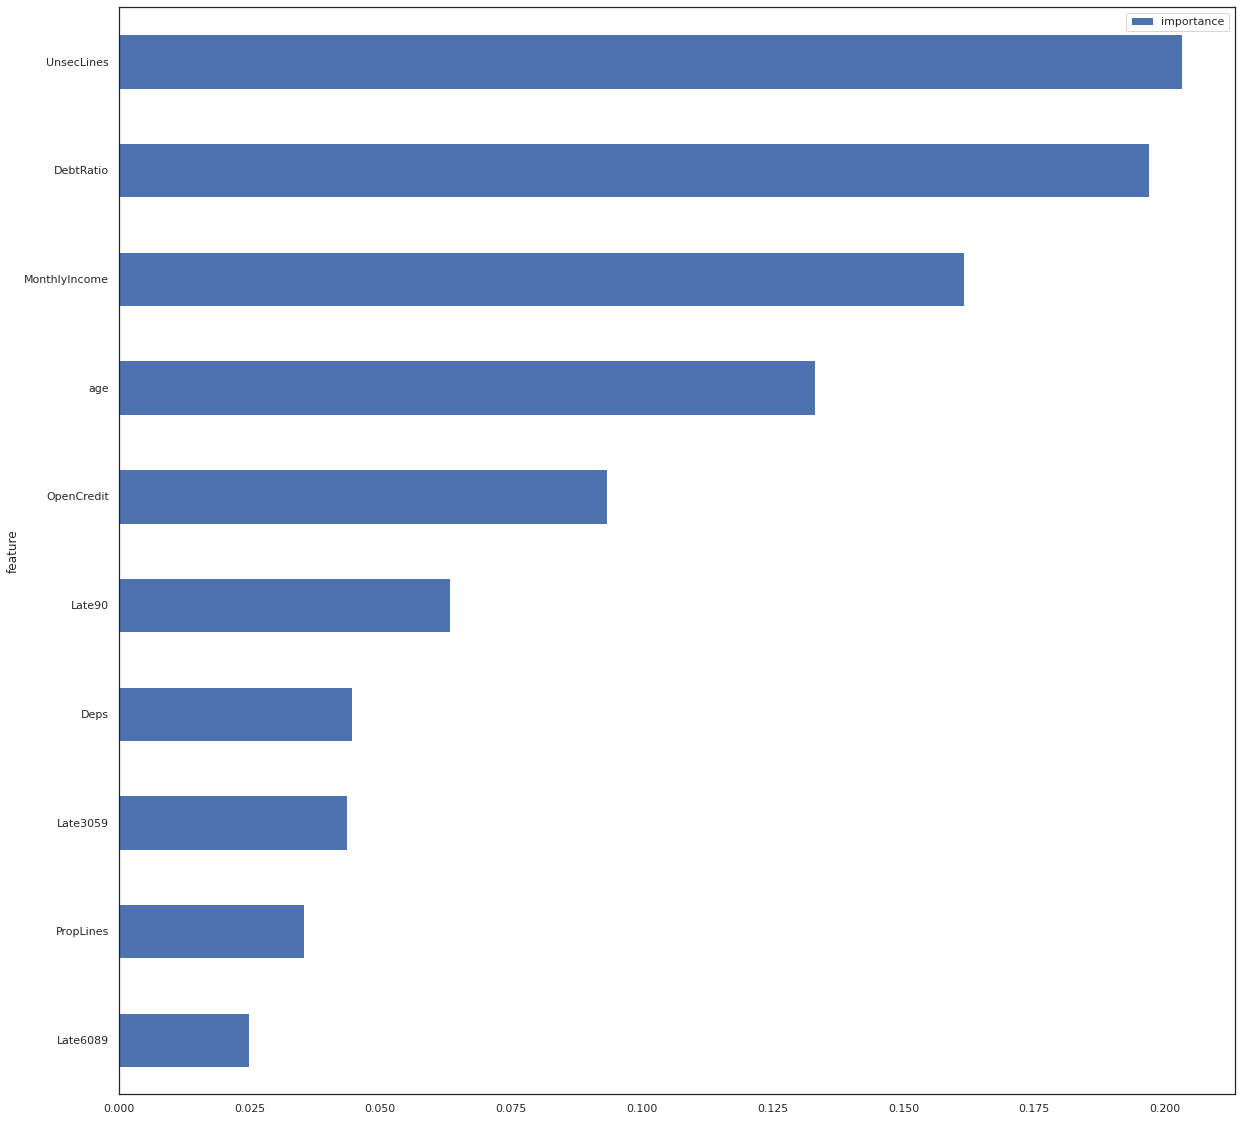

In [951]:
# Random Forest: Private-score= 0.85975, Public-score= 0.85478

clf = RandomForestClassifier(n_estimators=50, max_features='sqrt')
clf = clf.fit(X_train, Y_train)

features = pd.DataFrame()
features['feature'] = X_train.columns
features['importance'] = clf.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)

features.plot(kind='barh', figsize=(20, 20))

In [952]:
model = RandomForestClassifier(n_estimators=15, max_depth=6, random_state=0)
model.fit(X_train, Y_train)
y_pred = model.predict_proba(test_df)
y_pred = y_pred[:,1]
results_df.Target = y_pred

In [953]:
y_pred

array([0.09384049, 0.0368649 , 0.01798103, ..., 0.01064932, 0.10794958,
       0.03499777])

In [954]:
results_df = results_df.rename(columns={'Unknown': 'Id',
                                        'Target': 'Probability'})
results_df.head()

,Id,Probability
0,1,0.093840
1,2,0.036865
2,3,0.017981
3,4,0.052739
4,5,0.090254


In [955]:
results_df.to_csv("KAGGLE_CREDIT_SCORE.csv", index=False)